# Advance Lane Finding 

In this project I explore traditional computer vision techniques and create a program which tracks the lane lines in video footage taken from the front of a car.

software requirements:
 * python3
 * openCV
 * numpy
 

The completed pipeline can be executed using ``` python detect_lanes.py``` from the command line.
Each component of the pipeline was encapsulted into their own classes which can be found in the components module of the project.


## 1. camera calibration 

When a camera looks at 3D objects in the real world and transforms them into 2D images, a certain amount of information from the world gets distorted due to various factors such as lens curvature etc. We need to correct images taken from the camera by using a distortion matrix before information from the camera images can be used reliably.

A reliable way to calibrate the camera images is to use objects whose (x, y, z) coordinates with respect to the camera are known and correct for the same points on the camera images. To facilitate this idea we can use images of chessboard surfaces where the number of black/white box corners are known to be at a constant space from each other and the z coordinates lie on a flat plane.

The openCV library contains an utility function called ``` find_chessboard_images``` which can be used to determine the coordinates of the points on a given image of a chessboard.
The openCV library also contains an utility function called ```calibrateCamera``` which takes a set of image points and a set of object points and returns the distortion matrix along with other useful tranformation matrices.

I use the ```find_chessboard_images``` functions to determine the corners of chessboard images and generate object points which can be used to find the matrix.

This process is encapsulated in a class called ```Calibrator``` which is initialized in the beginning of the program and contains the undistort method which consistently undistorts images from the camera used to record the footage.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from components.utils import read_image
import cv2
import numpy as np
import glob


def display_original_and_transformed(image, 
                                     transormation_function, 
                                     transormation_title='transformed',
                                     cmap='jet'):
    
    original = image
    transormed = transormation_function(image)
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(1, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(original, cmap=cmap)
    ax.axis("off")
    ax.set_title('original image')
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(transormed, cmap=cmap)
    ax2.axis("off")
    ax2.set_title(transormation_title)

In [2]:
from components.calibrator import Calibrator
chessboard_image_sources = glob.glob('camera_cal/calibration*.jpg')
chessboard_images = [read_image(filename) for filename in chessboard_image_sources]
calibrator = Calibrator(chessboard_images)

demonstration of test calibration results

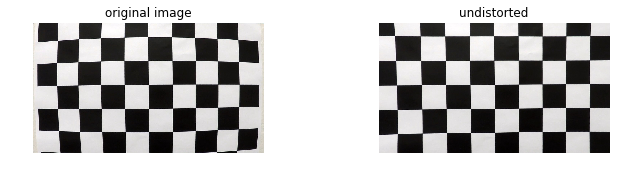

In [3]:
display_original_and_transformed(chessboard_images[0], calibrator.undistort, 'undistorted')

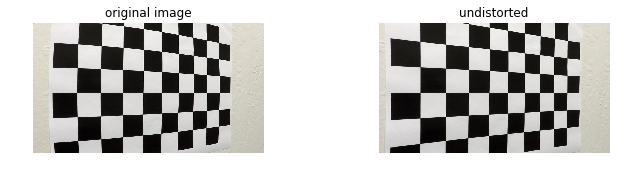

In [4]:
display_original_and_transformed(chessboard_images[15], calibrator.undistort, 'undistorted')

now that we know the calibration is working, lets apply it to the test image

since we are going to do multiple transformations on the images, i decided to create a pipeline class which lets me compose a series of transformations to the images.

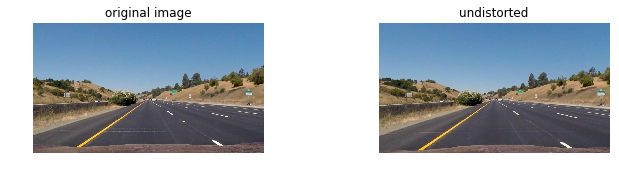

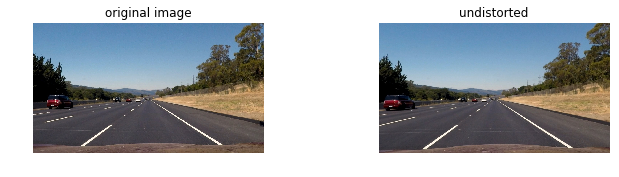

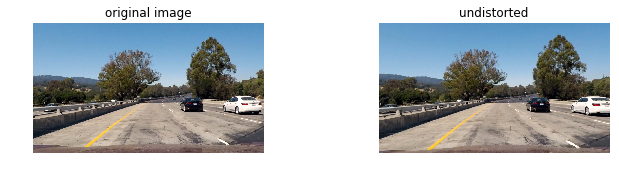

In [5]:
from components.pipeline import ImagePipeline
image_pipeline = ImagePipeline()
image_pipeline.add(calibrator.undistort)

test_image_files = glob.glob('test_images/*.jpg')
test_images = [read_image(imfile) for imfile in test_image_files]

for im  in test_images[:3] :
    display_original_and_transformed(im, image_pipeline.apply, 'undistorted')

## 2. Binary Images

After correctly correcting the camera images for distortion we convert the color image into a binary image consisting of 0 and 1s. We want to do this in a way that the binary image always captures the lanes on the road regardless of changes in the surface quality and shadows created by sorrounding objects. To do this I used a combination of 5 thresholding techniques:
* sobel thresholding in x direction
* sobel thresholding in y direction
* gradient magnitude thresholding
* gradient direction thresholding
* color thresholding on S channel in HSV colorspace

I encapsulated the process of making binary images into a class called ImageBinarizer which was then interactively updated to find the suitable parameters for each thresholding method.

In [6]:
from components.binarizer import ImageBinarizer

In [7]:
image_binarizer = ImageBinarizer(
    sobel_x_thresh=(20, 140),
    sobel_y_thresh=(15, 140),
    mag_thresh=(20, 140),
    dir_thresh=(0, 0.4),
    hls_thresh=(120, 200)
)


def select_y(
    sobel_x_min,
    sobel_x_max,
    sobel_y_min,
    sobel_y_max,
    mag_thresh_min,
    mag_thresh_max,
    dir_thresh_min,
    dir_thresh_max,
    hls_thresh_min,
    hls_thresh_max,
    im1,
    im2,
    im3,
    im4):
    image_binarizer.sobel_x_thresh = (sobel_x_min, sobel_x_max)
    image_binarizer.sobel_y_thresh = (sobel_y_min, sobel_y_max)
    image_binarizer.mag_thresh = (mag_thresh_min, mag_thresh_max)
    image_binarizer.dir_thresh = (dir_thresh_min, dir_thresh_max)
    image_binarizer.hls_thresh = (hls_thresh_min, hls_thresh_max)
    im1 = image_binarizer.binarize(im1)
    im2 = image_binarizer.binarize(im2)
    im3 = image_binarizer.binarize(im3)
    im4 = image_binarizer.binarize(im4)
    
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, top=0.5, bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(im1, cmap='gray')
    ax.axis("off")
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(im2, cmap='gray')
    ax2.axis("off")
    
    ax2 = plt.subplot(gs[2])
    plt.imshow(im3, cmap='gray')
    ax2.axis("off")

    ax2 = plt.subplot(gs[3])
    plt.imshow(im4, cmap='gray')
    ax2.axis("off")



<function __main__.select_y>

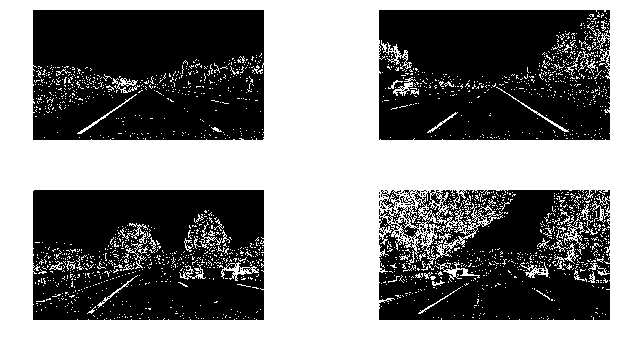

In [8]:
from ipywidgets import interact, fixed, IntSlider, FloatSlider
interact(
    select_y,
    sobel_x_min = IntSlider(min=0, max=255, step=1, value=20),
    sobel_x_max = IntSlider(min=0, max=255, step=1, value=255),
    sobel_y_min = IntSlider(min=0, max=255, step=1, value=32),
    sobel_y_max = IntSlider(min=0, max=255, step=1, value=255),
    mag_thresh_min = IntSlider(min=0, max=255, step=1, value=10),
    mag_thresh_max = IntSlider(min=0, max=255, step=1, value=255),
    dir_thresh_min = FloatSlider(min=0, max=np.pi/2, step=0.01, value=0),
    dir_thresh_max = FloatSlider(min=0, max=np.pi/2, step=0.01, value=0.5),
    hls_thresh_min = IntSlider(min=0, max=255, step=1, value=172),
    hls_thresh_max = IntSlider(min=0, max=255, step=1, value=255),
    im1=fixed(test_images[0]),
    im2=fixed(test_images[1]),
    im3=fixed(test_images[5]),
    im4=fixed(test_images[6]))

In [9]:
image_pipeline.add(image_binarizer.binarize)

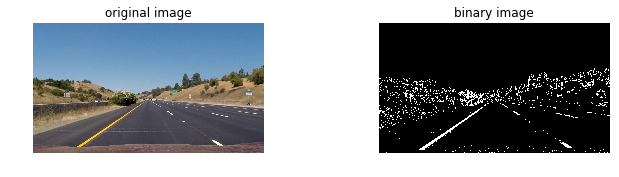

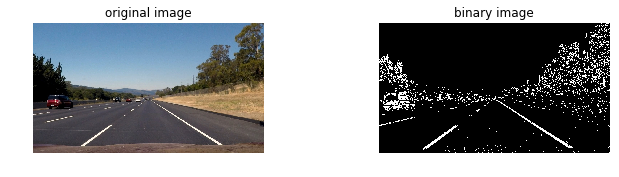

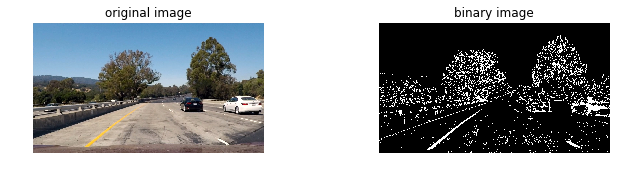

In [10]:
for im  in test_images[:3] :
    display_original_and_transformed(im, image_pipeline.apply, 'binary image', cmap='gray')

## 3.  Perspective Transformation

After converting the images to binary form, I transform the image to get a birds eye view of the road to be able to see the lane lines from a top view. To do this I created a region selector class which creates a trapezium on the image based on some assumptions:
* the road in front of the car is flat
* the camera is mounted on the center of the car.

the attributes of the class interactively updated to choose coordinates for an appropriate region of the image which represents the road plane. The chosen region is then transformed using ```cv2.warpTransform``` so that the coordinates represent a rectangle. 

In [11]:
from components.region_selector import RegionSelector

In [12]:
region_selector = RegionSelector()

In [13]:
def interactive_region_select(bottom_y, top_y, center_x, bottom_width, top_width, image):
    updated_image = region_selector.update_and_show(
        bottom_y,
        top_y,
        center_x,
        bottom_width,
        top_width,
        image
    )
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, top=0.5, bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(updated_image, cmap='gray')
    ax.axis("off")
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(region_selector.warp(image), cmap='gray')
    ax2.axis("off")

<function __main__.interactive_region_select>

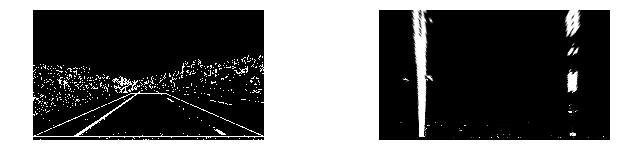

In [14]:

interact(
    interactive_region_select,
    bottom_y = IntSlider(min=0,max=750,step=10,value=700),
    top_y = IntSlider(min=0,max=750,step=10,value=460),
    center_x = IntSlider(min=0,max=1280,step=10,value=640),
    bottom_width = IntSlider(min=0,max=640,step=10,value=640),
    top_width = IntSlider(min=0,max=640,step=10,value=90),
    image=fixed(image_pipeline.apply(test_images[0])))
    

In [15]:
image_pipeline.add(region_selector.warp)

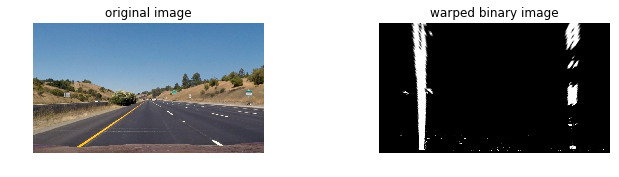

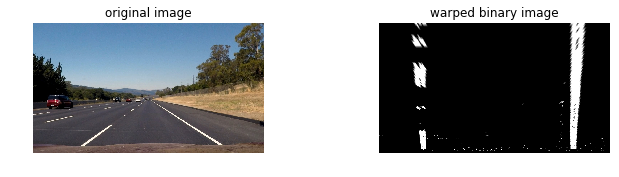

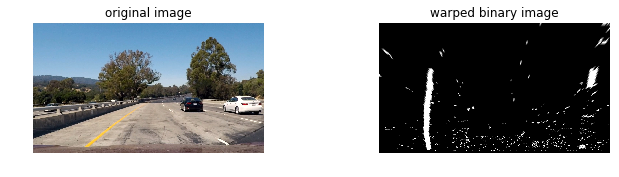

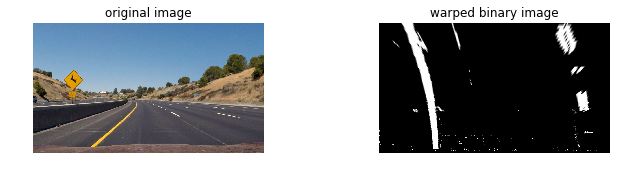

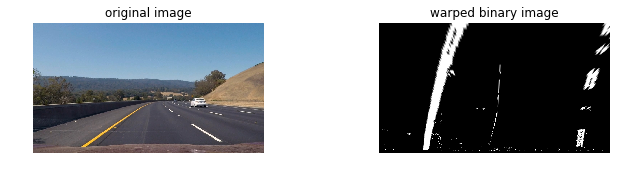

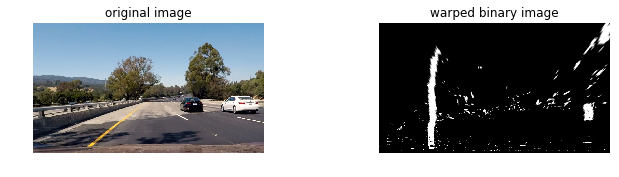

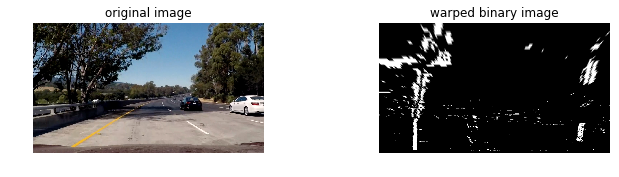

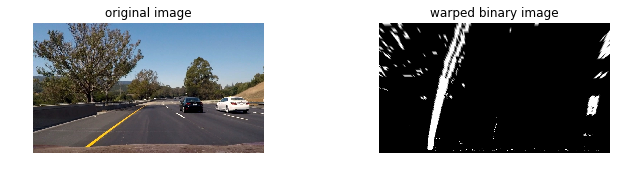

In [16]:
for im  in test_images :
    display_original_and_transformed(im, image_pipeline.apply, 'warped binary image', cmap='gray')

## 4. Lane estimation

After the perspective transforms of the binary images are done, we can now proceed to identifying the points of the image which represent a lane and then estimate polynomials which capture the line represented by the lane line.

To do this I took the bottom half of the image and found the histogram of the pixel values. Since the lanes were thresholded we find that the peaks of the histograms represent the position of pixels representing each lane.

I then create two lists for storing pixel indices representing the left lane and right lane. I populate this list by running a sliding window along the y axis for each lane starting at the position found by the histogram peaks and populate the indices lists with pixel positions representing each lane.

after determining which points represent each lane i estimate each lane polynomial by using the ```np.polyfit``` function. 

the polynomials found are then used to estimate the real life curvature of the road alogn with how much the car is offset from the center of the road.

I used the two polynomials to then generate polygon points which are then used to create a lane polygon to draw back to the image.

The entire process of determining appropriate lanes are encapsulated into a class called LaneFinder which can be updated to change number of sliding windows / and margins.

In [17]:
from components.lanefinder import LaneFinder
lane_finder = LaneFinder(image_binarizer,region_selector)

In [18]:
binary_warped = image_pipeline.apply(test_images[0])
left_fitx , right_fitx = lane_finder.show_line(binary_warped)

(720, 0)

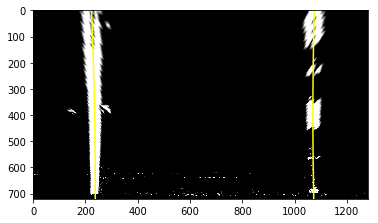

In [19]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
plt.imshow(binary_warped, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [20]:
image_pipeline.add(lane_finder.plot_lane_on_image)

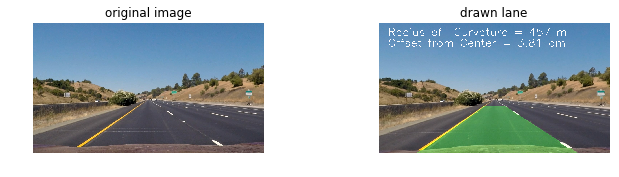

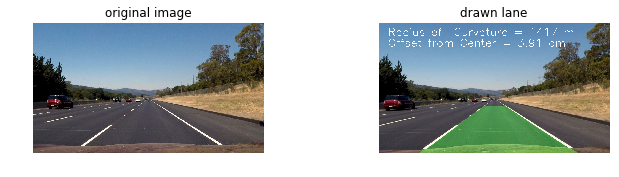

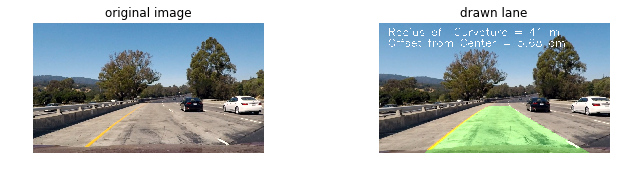

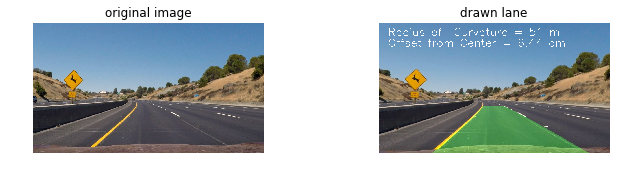

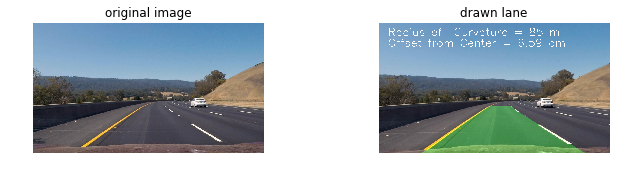

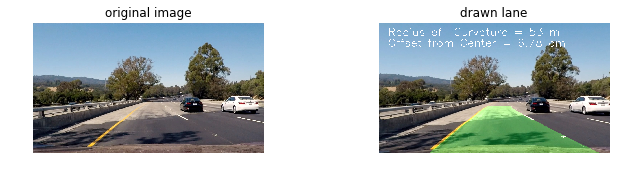

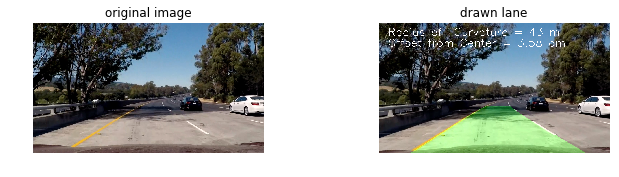

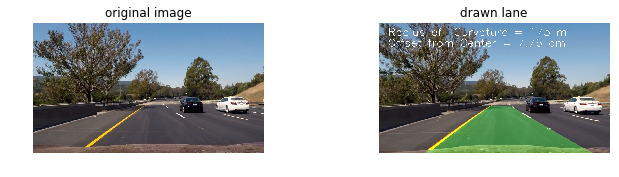

In [21]:
for im  in test_images :
    display_original_and_transformed(im, image_pipeline.apply, 'drawn lane', cmap='gray')

## 5. Complete Pipeline

after playing around with parameters in each of the steps of the pipeline, the completed image pipeline was encapsulated into a class called LaneDetector

In [22]:
class LaneDetector(object):

    def __init__(self, chessboard_images):
        self.image_pipeline = ImagePipeline()
        self.calibrator = Calibrator(chessboard_images)

        self.region_selector = RegionSelector()
        self.region_selector.update_points(700,460,640,640,90)
        
        self.binarizer = ImageBinarizer(
                                    sobel_x_thresh=(20, 255),
                                    sobel_y_thresh=(1, 255),
                                    mag_thresh=(32, 255),
                                    dir_thresh=(0, 0.5),
                                    hls_thresh=(172, 255))

        self.lanefinder = LaneFinder(self.binarizer, self.region_selector)

        self.image_pipeline.add(self.calibrator.undistort)
        self.image_pipeline.add(self.binarizer.binarize)
        self.image_pipeline.add(self.region_selector.warp)
        self.image_pipeline.add(self.lanefinder.plot_lane_on_image)        


    def detect(self, image):
        return self.image_pipeline.apply(image)

This lane detector class is then used to process each frame of the project video and generate the video with lanes in each frame identified.

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(LaneDetector.detect) #NOTE: this function expects color images!!
project_clip.write_videofile('main_project_output.mp4', audio=False)

[MoviePy] >>>> Building video main_project_output.mp4
[MoviePy] Writing video main_project_output.mp4


100%|█████████▉| 1260/1261 [06:23<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: main_project_output.mp4 



## Reflection

While the lane finding project performs decent on the project video there are quite a few limitations to the approach that was taken :
1. the entire pipeline is dependant on the quality of binary images generated. the parameters for this video were specifically tuned to daylight conditions which may mean that this model is not robust enough to behave well in the night.
2. the assumptions used to create the pipeline were based on car traveling on fairly flat surface and along the road. It probably doesnt capture the lanes well on a very rapidly changing surface or when the car is not in ideal situations such as during accidents or swerves.
3. while the pipeline works for most of the video, there are certain situations where it doesnt do too well. The algorithm ive implemented did not take into consideration historical information from previous frames of the video which could be used to determine the confidence of the detection algorithm and generate a smoother output result.
4. in a future iteration i would like to explore deep learning algorithms to determine the segmentation of the lanes as i think intuitively the convolution layers would result in more robust features than the thresholding techniques used.